# Target


*   Train the model for less than 15 epochs.
*   Add transformations(image rotation of ±7 degrees) to achieve over 99.4% accuracy.

# Result

*   Params = 9,922
*   Best Train Accuracy = 98.23% at 14th epoch
*   Best Test Accuracy = 99.40% at 12th epoch

# Analysis

*   The model is underfitting.
*   The model reaches 99.40% accuracy once but is not consistent with validation accuracy. If trained for more epochs, it may bring the results but it would be slightly difficult since the model is training very slowly.


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
!pip install torchsummary

## Model

In [ ]:
dropout_value = 0.10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=0),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU() 
        ) # output_size = 26

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=0),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU() 
        ) # output_size = 24

        # transition block 
        self.conv_1_1 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=1), 
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 12
        # end

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=0),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 10

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3, padding = 0),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 8

        #
        # self.conv5 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1), 
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value),
        #     nn.ReLU()
        # )

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding = 0), 
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding = 1),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6( padding = 1)

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size = 6)
        ) # output_size = 1

        # final FC layer (read fully convolutional, not fully connected)
        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=1),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )

        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=1)
        )

        self.dropout = nn.Dropout(dropout_value)
    
    def forward(self, x):
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv_1_1(x)
            x = self.conv3(x)
            x = self.conv4(x)
            # x = self.conv5(x)
            x = self.conv6(x)
            x = self.conv7(x)
            x = self.gap(x)
            x = self.conv8(x)
            x = self.conv9(x)

            x = x.view(-1, 10)
            return F.log_softmax(x)


## Model Summary

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,820
       BatchNorm2d-6           [-1, 20, 24, 24]              40
           Dropout-7           [-1, 20, 24, 24]               0
              ReLU-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             210
        MaxPool2d-10           [-1, 10, 12, 12]               0
      BatchNorm2d-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
             ReLU-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1, 10,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

## Data loading and transformations

In [ ]:
torch.manual_seed(1) # for consistent output
batch_size = 64

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

# train data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)), # rotation of 5 to 10 degrees would suffice
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # mean, std of the data
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

# test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


## Train and Test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad() # setting the gradients to zero after every backprop step
    y_pred = model(data) # predicting the values
    loss = F.nll_loss(y_pred, target) # calculating the loss using negative loss likelihood
    train_losses.append(loss)
    loss.backward() # backpropagation
    optimizer.step()
    pred = y_pred.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    accuracy = 100. * correct / processed

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100. * correct / processed:0.2f}')
    train_acc.append(100. * correct / processed)
    # return accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # since we do not want to compute gradients on the test data, we use torch.no_grad()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Training and Testing

In [ ]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 15):
    print('Epoch:',  epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.36412131786346436 Batch_id=937 Accuracy=89.27: 100%|██████████| 938/938 [00:20<00:00, 45.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0579, Accuracy: 9825/10000 (98.25%)

Epoch: 2


Loss=0.07300962507724762 Batch_id=937 Accuracy=96.04: 100%|██████████| 938/938 [00:20<00:00, 45.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9863/10000 (98.63%)

Epoch: 3


Loss=0.1536412239074707 Batch_id=937 Accuracy=96.95: 100%|██████████| 938/938 [00:20<00:00, 46.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9894/10000 (98.94%)

Epoch: 4


Loss=0.021314749494194984 Batch_id=937 Accuracy=97.21: 100%|██████████| 938/938 [00:20<00:00, 45.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9913/10000 (99.13%)

Epoch: 5


Loss=0.2063341587781906 Batch_id=937 Accuracy=97.40: 100%|██████████| 938/938 [00:20<00:00, 45.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9907/10000 (99.07%)

Epoch: 6


Loss=0.022460458800196648 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [00:20<00:00, 46.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9914/10000 (99.14%)

Epoch: 7


Loss=0.022987965494394302 Batch_id=937 Accuracy=97.73: 100%|██████████| 938/938 [00:20<00:00, 45.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9925/10000 (99.25%)

Epoch: 8


Loss=0.10509763658046722 Batch_id=937 Accuracy=97.94: 100%|██████████| 938/938 [00:20<00:00, 45.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9926/10000 (99.26%)

Epoch: 9


Loss=0.11675279587507248 Batch_id=937 Accuracy=97.95: 100%|██████████| 938/938 [00:20<00:00, 45.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9922/10000 (99.22%)

Epoch: 10


Loss=0.021399732679128647 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:20<00:00, 45.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9923/10000 (99.23%)

Epoch: 11


Loss=0.006623483262956142 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [00:20<00:00, 46.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9931/10000 (99.31%)

Epoch: 12


Loss=0.09372088313102722 Batch_id=937 Accuracy=98.19: 100%|██████████| 938/938 [00:20<00:00, 45.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9940/10000 (99.40%)

Epoch: 13


Loss=0.011343151330947876 Batch_id=937 Accuracy=98.19: 100%|██████████| 938/938 [00:20<00:00, 46.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9927/10000 (99.27%)

Epoch: 14


Loss=0.1988430917263031 Batch_id=937 Accuracy=98.23: 100%|██████████| 938/938 [00:20<00:00, 45.85it/s]



Test set: Average loss: 0.0260, Accuracy: 9927/10000 (99.27%)



## Plotting

Text(0.5, 1.0, 'Test Accuracy')

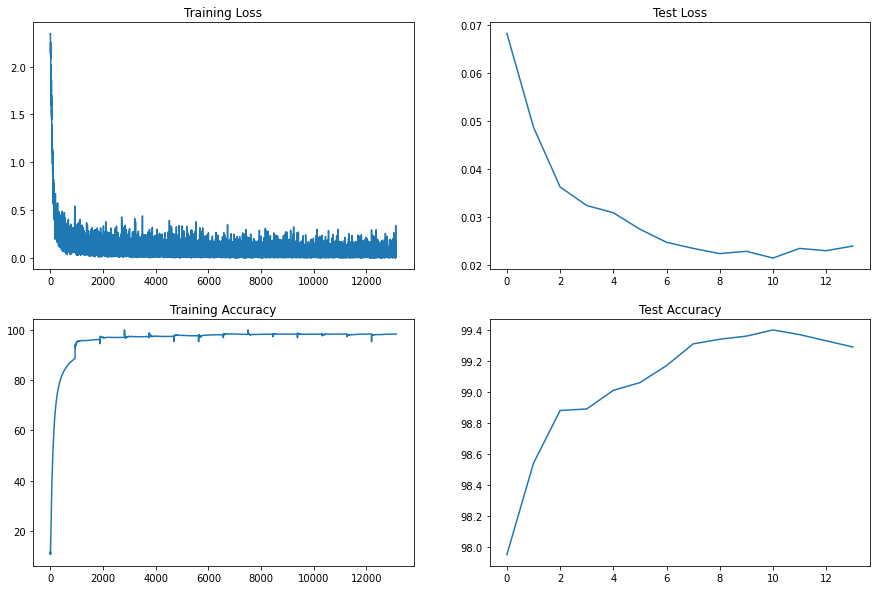

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")